In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
# ==== データ読み込み ====
df = pd.read_excel("Dataset_Simulated_Price_swaption.xlsx")
col_name = "Tenor : 1; Maturity : 0.0833333333333333"
data = df[col_name].dropna().values

# # ==== 特徴量作成 ====
window = 20
# オフセット
offset = 1
X, y = [], []
for i in range(len(data) - window):
    X.append(data[i:i+window])
    # y.append(data[i+window])
    y.append(data[i+window + offset - 1])
X, y = np.array(X), np.array(y)

# ==== データ数を制限 ====
# N_samples = 200  # 使用するサンプル数
# X, y = X[-N_samples:], y[-N_samples:]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ==== 訓練・テスト分割 ====
# split = int(len(X) * 0.8)
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]
split = int(len(X_scaled)*0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

### RBF kernel

In [3]:
# === 4. RBFカーネル回帰モデル ===
# gamma = 1/(2σ^2)
model = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
model.fit(X_train, y_train)

,alpha,0.1
,kernel,'rbf'
,gamma,0.5
,degree,3
,coef0,1
,kernel_params,None


In [4]:
# === 5. 予測 ===
y_pred = model.predict(X_test)

# === 6. 評価 ===
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"MSE: {mse:.6e}")

MSE: 1.478228e-06


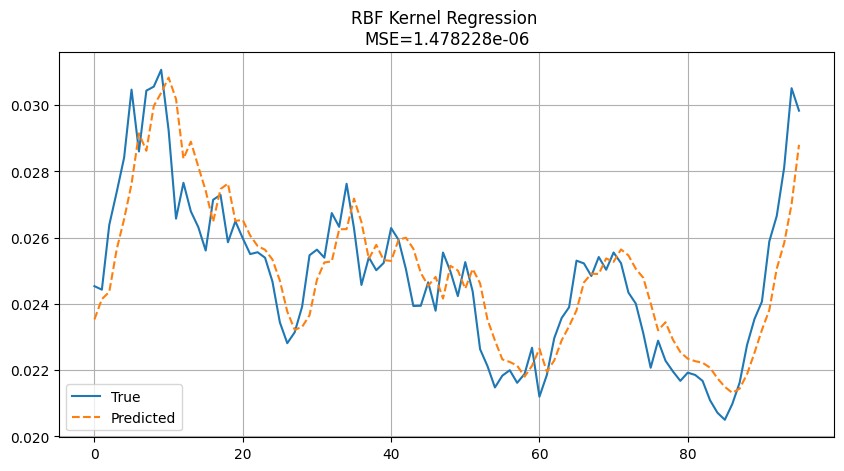

In [5]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="True")
plt.plot(y_pred_inv, label="Predicted", linestyle="--")
plt.legend()
plt.title(f"RBF Kernel Regression \nMSE={mse:.6e}")
plt.grid(True)
plt.show()

### Quantum kernel (Simulator)

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.quantum_info import Statevector

In [ ]:
# ==== 量子特徴マップ ====
num_qubits = X_train.shape[1]
print(f"Number of qubits: {num_qubits}")
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
sim_backend = AerSimulator(method="statevector")  # ローカルの statevector シミュレータ
# service = QiskitRuntimeService()
# service.backends()
# backend = service.backend('ibm_fez') 
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

Number of qubits: 20


/var/folders/4t/f9s2s80n15d24fg2pl23l77c0000gn/T/ipykernel_12408/2831937073.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")


最も空いているバックエンドは:  <IBMBackend('ibm_fez')>


In [8]:
n1, n2 = len(X_train), len(X_train)
kernel = np.zeros((n1, n2))
circuits = []
index_map = []

# # すべてのペア (X1[i], X2[j]) に対して回路を構築
# qc_i = create_feature_circuit(feature_map, X_train[2]).inverse()
# qc_j = create_feature_circuit(feature_map, X_train[4])
# qc = QuantumCircuit(num_qubits)
# qc.compose(qc_i, inplace=True)
# qc.compose(qc_j, inplace=True)
# qc.measure_all()
# # circuits.append(qc)
# # index_map.append((i, j))
# qc.draw('mpl', idle_wires=False)
# plt.show()

In [14]:
def create_feature_circuit(feature_map, x):
    """パラメータを割り当てた回路を返す（transpile は実行時に行う）"""
    qc = feature_map.assign_parameters({p: v for p, v in zip(feature_map.parameters, x)})
    qc = qc.decompose(reps=3)
    return qc


def quantum_kernel_matrix_measurement(feature_map, X1, X2, backend, shots=1024, batch_size=10):
    """実機で K[i,j] = |<phi(X1[i])|phi(X2[j])>|^2 を測定ベースで推定"""
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    circuits = []
    index_map = []

    # すべてのペア (X1[i], X2[j]) に対して回路を構築
    for i in range(n1):
        qc_i = create_feature_circuit(feature_map, X1[i]).inverse()
        for j in range(n2):
            qc_j = create_feature_circuit(feature_map, X2[j])
            qc = QuantumCircuit(num_qubits)
            qc.compose(qc_i, inplace=True)
            qc.compose(qc_j, inplace=True)
            qc.measure_all()
            circuits.append(qc)
            index_map.append((i, j))
            # qc.draw('mpl', idle_wires=False)
            # plt.show()
            # return
    
    # circuit を表示する
    circuits[-1].draw('mpl')  # 'mpl' は matplotlib で描画する方法

    sampler = SamplerV2(mode=backend)  # ← Sessionを使わない

    print(f"length of circuits: {len(circuits)}")

    for start in range(0, len(circuits), batch_size):
        batch = circuits[start:start + batch_size]
        batch_map = index_map[start:start + batch_size]

        # トランスパイル（ローカルで最適化）
        transpiled = transpile(batch, backend=backend, optimization_level=3)

        # ジョブ送信
        job = sampler.run(transpiled, shots=shots)
        # print(f"Submitted job {job.job_id()} with {len(batch)} circuits. Waiting...")

        # 完了を待機
        result = job.result()
        # print(f"Job {job.job_id()} finished.")
                
        # SamplerV2の結果からカーネル値を計算
        for idx, pub_result in enumerate(result):  # result は PrimitiveResult
            # 各回路の測定結果を取得
            # デフォルトでは register 名は 'meas' か 'alpha' などになる
            bit_array = pub_result.data.meas  # または pub_result.data.alpha など
            counts = bit_array.get_counts()   # {bitstring: count, ...} の辞書を取得

            # |00...0> のカウントを確率に変換
            zeros = '0' * num_qubits
            prob_zero = counts.get(zeros, 0) / sum(counts.values())

            # i, j インデックスを対応付け
            i, j = batch_map[idx]
            kernel[i, j] = prob_zero

    return kernel


# def quantum_kernel_matrix(feature_map, X1, X2, backend=None, shots=1024, batch_size=10):
#     """バックエンドがシミュレータならstatevectorで正確に計算、実機なら測定ベースで推定"""
#     if backend is None:
#         backend = sim_backend

#     # ==========================
#     # シミュレーターの場合
#     # ==========================
#     if getattr(backend.configuration(), 'simulator', False):
#         n1, n2 = len(X1), len(X2)
#         kernel = np.zeros((n1, n2))

#         # φ(X1) と φ(X2) の状態ベクトルを取得してキャッシュ
#         state_cache1, state_cache2 = [], []

#         for x in X1:
#             qc = create_feature_circuit(feature_map, x)
#             qc.save_statevector()
#             t = transpile(qc, backend=backend)
#             res = backend.run(t).result()
#             state = res.get_statevector(0)
#             state_cache1.append(state)

#         for x in X2:
#             qc = create_feature_circuit(feature_map, x)
#             qc.save_statevector()
#             t = transpile(qc, backend=backend)
#             res = backend.run(t).result()
#             state = res.get_statevector(0)
#             state_cache2.append(state)

#         # 内積からカーネル値を計算
#         for i, si in enumerate(state_cache1):
#             for j, sj in enumerate(state_cache2):
#                 kernel[i, j] = np.abs(np.vdot(si, sj)) ** 2

#         return kernel

#     # ==========================
#     # 実機またはショットベースのバックエンドの場合
#     # ==========================
#     else:
#         print("Note: using measurement-based kernel estimation on real backend.")
#         return quantum_kernel_matrix_measurement(
#             feature_map, X1, X2, backend, shots=shots, batch_size=batch_size
#         )

def quantum_kernel_matrix(feature_map, X1, X2, backend=None, shots=1024, batch_size=10):
    """Statevector を使って高速に量子カーネル行列を計算"""
    # ==========================
    # シミュレーター（Statevector計算）
    # ==========================
    if backend is None or getattr(backend.configuration(), 'simulator', False):
        print("Note: using statevector-based kernel calculation on simulator.")
        n1, n2 = len(X1), len(X2)
        kernel = np.zeros((n1, n2))

        # φ(X1) と φ(X2) の状態ベクトルをキャッシュ
        state_cache1 = [Statevector.from_instruction(create_feature_circuit(feature_map, x)) for x in X1]
        state_cache2 = [Statevector.from_instruction(create_feature_circuit(feature_map, x)) for x in X2]

        print("fin statevector calculation")
        
        # 内積からカーネル値を計算
        print(f"length of state_cache1: {len(state_cache1)}")
        for i, si in enumerate(state_cache1):
            for j, sj in enumerate(state_cache2):
                kernel[i, j] = np.abs(si.data.conj().dot(sj.data)) ** 2
            print(f"calculated row {i+1}/{n1}")

        return kernel

    # ==========================
    # 実機またはショットベースのバックエンドの場合
    # ==========================
    else:
        print("Note: using measurement-based kernel estimation on real backend.")
        return quantum_kernel_matrix_measurement(
            feature_map, X1, X2, backend, shots=shots, batch_size=batch_size
        )


In [15]:
# K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=sim_backend)
# K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=sim_backend)
K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=None)
K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=None)

Note: using statevector-based kernel calculation on simulator.


KeyboardInterrupt: 

In [24]:
# ==== 回帰 ====
model = KernelRidge(alpha=1.0, kernel="precomputed")
model.fit(K_train, y_train)
y_pred = model.predict(K_test)

In [25]:
# ==== 逆スケーリング & 評価 ====
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test_inv = y_test
# y_pred_inv = y_pred
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"MSE: {mse:.6f}")

MSE: 0.000015


### Quantum kernel (real machine)

- 計算時間より、計算不能

In [71]:
# K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=sim_backend)
# K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=sim_backend)
K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=backend)
K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=backend)

Note: using measurement-based kernel estimation on real backend.
Note: using measurement-based kernel estimation on real backend.


In [ ]:
# ==== 回帰 ====
model = KernelRidge(alpha=1.0, kernel="precomputed")
model.fit(K_train, y_train)
y_pred = model.predict(K_test)

In [ ]:
# ==== 逆スケーリング & 評価 ====
# y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
# y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test_inv = y_test
# y_pred_inv = y_pred
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.6f}")